In [0]:
from google.colab import files
files.upload();

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


In [0]:
!kaggle datasets download -d andrewmvd/japanese-female-facial-expression-dataset-jaffe
!unzip -q japanese-female-facial-expression-dataset-jaffe.zip
!rm -r *.zip

 95% 11.0M/11.6M [00:00<00:00, 13.4MB/s]
100% 11.6M/11.6M [00:00<00:00, 14.9MB/s]


In [0]:
import pandas as pd
import numpy as np
result = pd.read_csv('data.csv')
result.head()

,filepath,student,facial_expression
0,images/KA.AN1.39.tiff,KA,angry
1,images/KA.AN2.40.tiff,KA,angry
2,images/KA.AN3.41.tiff,KA,angry
3,images/KA.DI1.42.tiff,KA,disgust
4,images/KA.DI2.43.tiff,KA,disgust


In [0]:
from keras.preprocessing.image import load_img, img_to_array, array_to_img
images = result.filepath.values
images = np.array( [ img_to_array(load_img( path, target_size=(128,128) )) for path in images] )
expression = result.facial_expression.values
images.shape

Using TensorFlow backend.


(213, 128, 128, 3)

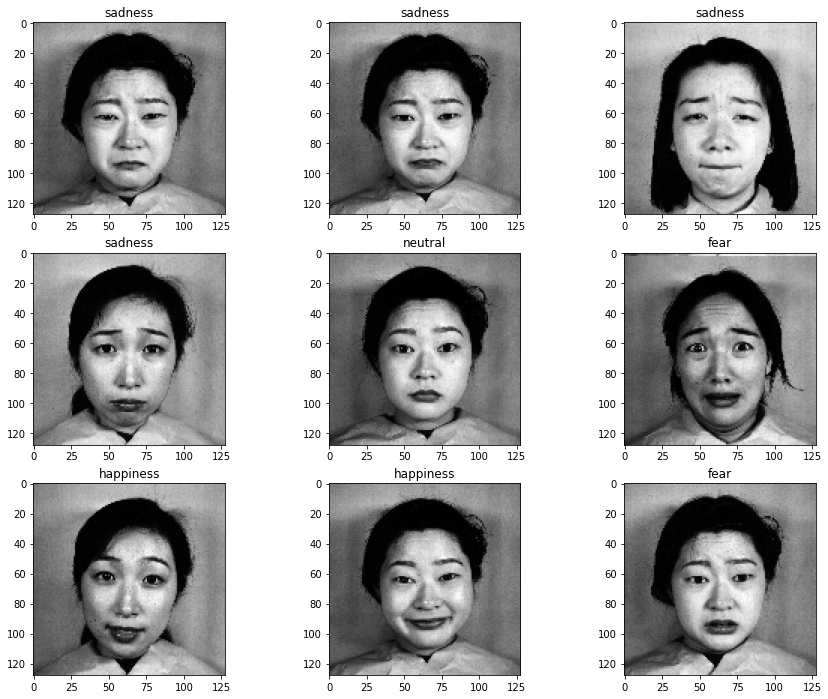

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

figure, ax = plt.subplots( nrows=3, ncols=3, figsize=(15,12) )
indexes = np.random.choice( len(result), size=9 )
for i, index in enumerate(indexes):
  ax[i//3][i%3].imshow( images[index][ :,:,0 ], cmap='gray' )
  ax[i//3][i%3].set_title( expression[index] )

In [0]:
from keras.applications.vgg16 import preprocess_input
images = preprocess_input(images)
images.shape

(213, 128, 128, 3)

In [0]:
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import optimizers
from keras.applications.vgg16 import VGG16

vggmodel = VGG16(weights='imagenet', include_top=False, input_shape=(128,128,3))
for layer in vggmodel.layers:
  layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [0]:
flatten = Flatten()(vggmodel.output)
predictions = Dense(7, activation="softmax")(flatten)
model_final = Model(input = vggmodel.input, output = predictions)
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

lbl = LabelEncoder()
expression_lbl = lbl.fit_transform( expression )

expression_ohe = to_categorical( expression_lbl, num_classes=7 )
expression_lbl.shape, expression_ohe.shape

((213,), (213, 7))

In [0]:
model_final.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [0]:
from sklearn.model_selection import train_test_split
trainX, valX, trainY, valY = train_test_split( images, expression_ohe, test_size=0.15, 
                                              stratify=expression, random_state=10 )
trainX.shape, valX.shape, trainY.shape, valY.shape

((181, 128, 128, 3), (32, 128, 128, 3), (181, 7), (32, 7))

In [0]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

history = model_final.fit( trainX, trainY, 
                          epochs=50, batch_size=32, verbose=1, 
                          validation_data = ( valX, valY ),
                          callbacks = [ early ] )

Train on 181 samples, validate on 32 samples
Epoch 1/50
181/181 [==============================] - 8s 46ms/step - loss: 12.1510 - accuracy: 0.1381 - val_loss: 8.0472 - val_accuracy: 0.0625
Epoch 2/50
181/181 [==============================] - 0s 2ms/step - loss: 5.8443 - accuracy: 0.2928 - val_loss: 5.2504 - val_accuracy: 0.2500
Epoch 3/50
181/181 [==============================] - 0s 2ms/step - loss: 2.4892 - accuracy: 0.4972 - val_loss: 4.6700 - val_accuracy: 0.4062
Epoch 4/50
181/181 [==============================] - 0s 2ms/step - loss: 1.3544 - accuracy: 0.7072 - val_loss: 3.0498 - val_accuracy: 0.4375
Epoch 5/50
181/181 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.8122 - val_loss: 2.3969 - val_accuracy: 0.5312
Epoch 6/50
181/181 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8785 - val_loss: 1.2824 - val_accuracy: 0.7188
Epoch 7/50
181/181 [==============================] - 0s 2ms/step - loss: 0.1034 - accuracy: 0.9724 -

In [0]:
model_final.save_weights("vgg16_1.h5")

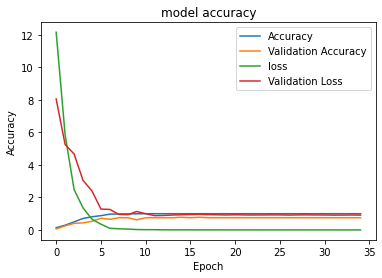

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

<Figure size 432x288 with 0 Axes>

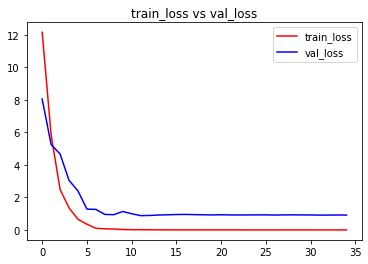

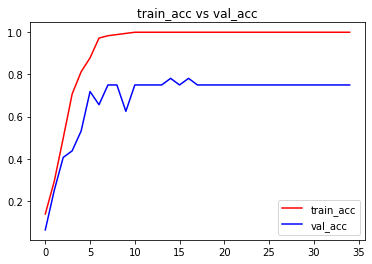

<Figure size 432x288 with 0 Axes>

In [0]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()
plt.figure()

In [0]:
# from keras.preprocessing import image
# img = image.load_img("men.jpg",target_size=(128,128))
# img = np.asarray(img)
# plt.imshow(img)
# img = np.expand_dims(img, axis=0)
# from keras.models import load_model
# saved_model = load_model("vgg16_1.h5")
# output = saved_model.predict(img)


In [0]:
import numpy as np

In [0]:
files.upload();

Saving men.jpg to men.jpg


In [0]:
testing_data_list=[ 'men.jpg', 'images/KA.FE2.46.tiff', 'images/KA.HA1.29.tiff', 'images/KA.DI3.44.tiff' ]
test = np.array( [ img_to_array(load_img( path, target_size=(128,128) )) for path in testing_data_list], dtype=np.int64 )
test_final = preprocess_input(test)
test_final.shape

(4, 128, 128, 3)

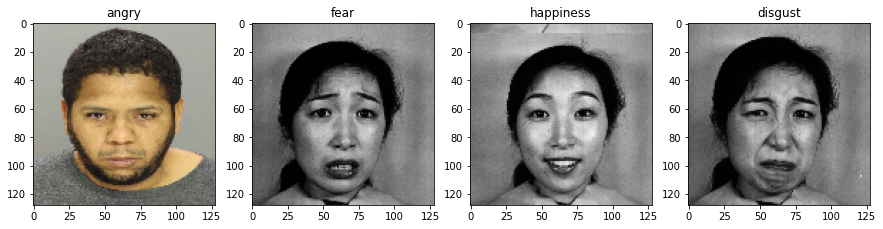

In [0]:
results = model_final.predict(test_final)
predicted_expressions = lbl.inverse_transform(np.argmax(results, axis=1))

total = len(test)
nr = (total//4)+1
nc = 4
fig = plt.figure(figsize=(15,4*nr))

for i in range(total):
  x = fig.add_subplot(nr,nc,i+1)
  x.imshow( test[i] )
  x.set_title( predicted_expressions[i] )

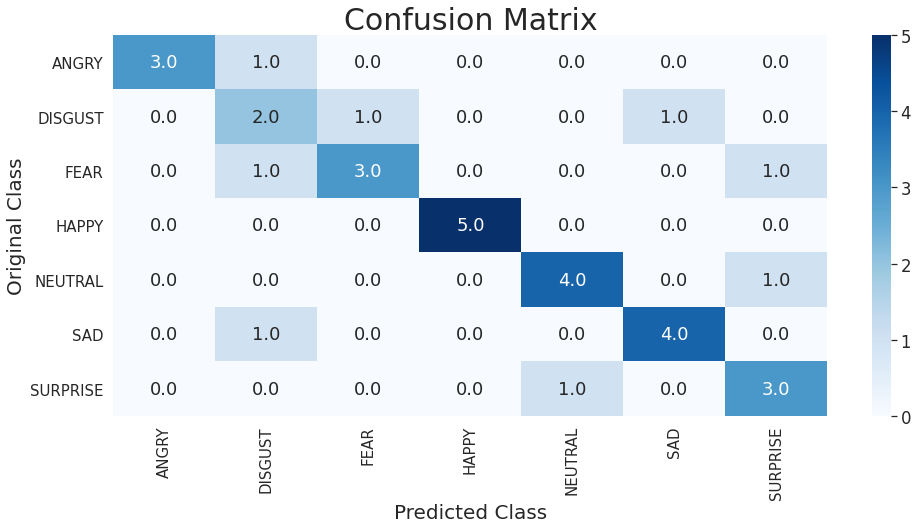

-----------------------------------------------------------------------------------------------------------------------------


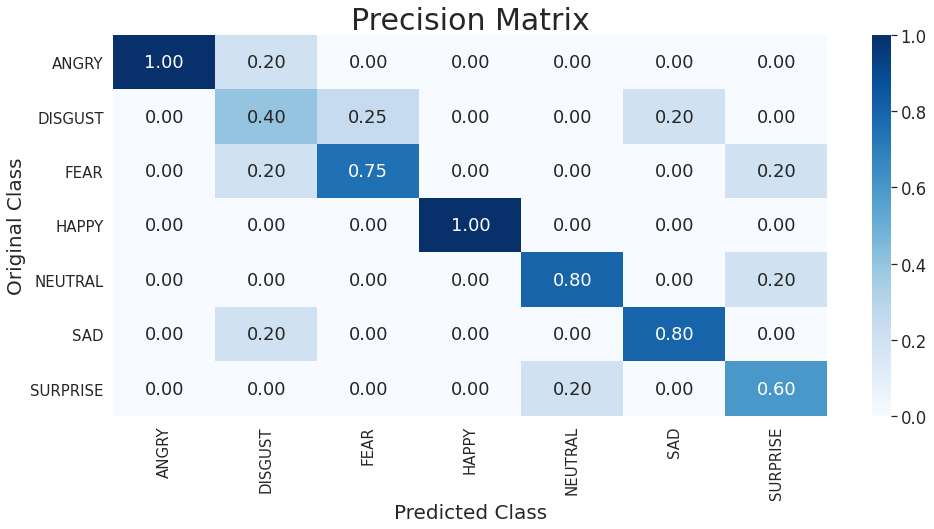

-----------------------------------------------------------------------------------------------------------------------------


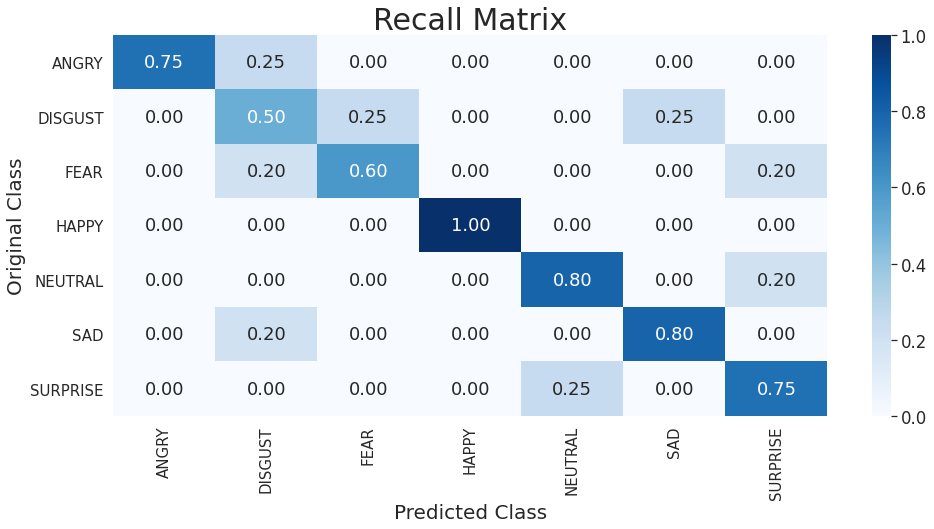

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
results = model_final.predict(valX) 

confusionMatx = confusion_matrix(lbl.fit_transform(np.argmax(valY, axis=1)),lbl.fit_transform(np.argmax(results, axis=1)) )

#accuracy = confusionMatx[0,0] +confusionMatx[0,1]/

precision = confusionMatx/confusionMatx.sum(axis = 0)
recall = (confusionMatx.T/confusionMatx.sum(axis = 1)).T

# print(confusionMatx)
# print(precision)
# print(recall)
    
sns.set(font_scale=1.5)

    
labels = ["ANGRY", "DISGUST", "FEAR", "HAPPY", "NEUTRAL", "SAD", "SURPRISE"]
    
plt.figure(figsize=(16,7))
sns.heatmap(confusionMatx, cmap = "Blues", annot = True, fmt = ".1f", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix", fontsize = 30)
plt.xlabel('Predicted Class', fontsize = 20)
plt.ylabel('Original Class', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 90)
plt.show()
print("-"*125)
    
plt.figure(figsize=(16,7))
sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
plt.title("Precision Matrix", fontsize = 30)
plt.xlabel('Predicted Class', fontsize = 20)
plt.ylabel('Original Class', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 90)
plt.show()
    
print("-"*125)
    
plt.figure(figsize=(16,7))
sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".2f", xticklabels=labels, yticklabels=labels)
plt.title("Recall Matrix", fontsize = 30)
plt.xlabel('Predicted Class', fontsize = 20)
plt.ylabel('Original Class', fontsize = 20)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 90)
plt.show()
    